In [1]:
!unzip validated.zip

Streaming output truncated to the last 5000 lines.
  inflating: validated/80ac1211-1b2a-425e-acd7-d2bcdad80934.json  
  inflating: validated/80AFA9CB-F969-489A-8F5D-AE7D7049DAFE.json  
  inflating: validated/80b3e565-160e-4479-8b45-9190f0fcd19a.json  
  inflating: validated/80b7ddc4-d3d9-4598-bdaa-847571f919aa.json  
  inflating: validated/80BA819B-DB2B-4F4B-8A4C-B4154C7F84B8.json  
  inflating: validated/80bd3990-90c8-4f62-988a-831b321ebb15.json  
  inflating: validated/80BDAF62-1415-4E35-91C2-B1C76C9344C1.json  
  inflating: validated/80BE1C1D-23DE-4A7A-AA67-5F4138529C7B.json  
  inflating: validated/80C48D4D-E246-458F-8020-A939E3CBBB85.json  
  inflating: validated/80C88C00-74AD-44F0-98E2-49AB5B32E6DC.json  
  inflating: validated/80CBB49D-6524-4DB4-80A7-148A2C241CD6.json  
  inflating: validated/80D741B7-7B13-4370-9223-DF6742BF6761.json  
  inflating: validated/80D91EE2-8F49-44FB-800C-92A3405FFC07.json  
  inflating: validated/80DBF444-160A-4F05-B7F3-20A351C02EA8.json  
  inflating

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
###1数据预处理###
##1.1导入数据##
import os
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns


# 定义包含JSON文件的文件夹路径
folder_path = './validated'
# 初始化一个列表来存储所有事件数据
all_events = []
# 遍历文件夹中的所有文件
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # 只处理JSON文件
        file_path = os.path.join(folder_path, filename)
        # 打开并解析JSON文件
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                event_data = json.load(file)
                all_events.append(event_data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {filename}: {e}")

##1.2提取关键信息##
"""
- Which countries are disproportionately high targets of cybercrimes?
- Where are cybercrimes successful?
- Where are cybercrimes thwarted
- Where are cybercrimes reported, where are cybercrimes prosecuted?
"""

# 提取关键信息，并删除存在缺失值的记录
extracted_events = []
for event in all_events:
    # 检查所有需要的字段是否存在
    if all(key in event for key in ['action', 'actor', 'asset', 'attribute', 'discovery_method', 'impact', 'timeline', 'victim']):
        extracted_event = {
            'timeline': event['timeline'],
            'victim': event['victim'],
            'action': event['action'],
            'actor': event['actor'],
            'asset': event['asset'],
            'attribute': event['attribute'],
            'discovery_method': event['discovery_method'],
            'impact': event['impact'],
        }
        extracted_events.append(extracted_event)


events_victim_country_only = [{"country": e["victim"]["country"][0]} for e in extracted_events if e.get("victim", {}).get("country", [])]
events_victim_name = [{"name": e["victim"]["victim_id"]} for e in extracted_events if e.get("victim", {}).get("victim_id")]

# 定义要保留和去除的键
keys_to_remove_actor = ['country', 'region']
keys_to_remove_asset = ['amount']
keys_to_remove_timeline = ['day', 'month']
keys_to_keep_victim = ['country']
keys_to_keep_impact = ['loss']

print(json.dumps(events_victim_name[0], indent=2))

{
  "name": "Feinstein Institute"
}


country
US         4240
GB          432
CA          267
Unknown     136
AU          105
           ... 
MA            1
NA            1
TT            1
UZ            1
LU            1
Name: count, Length: 107, dtype: int64


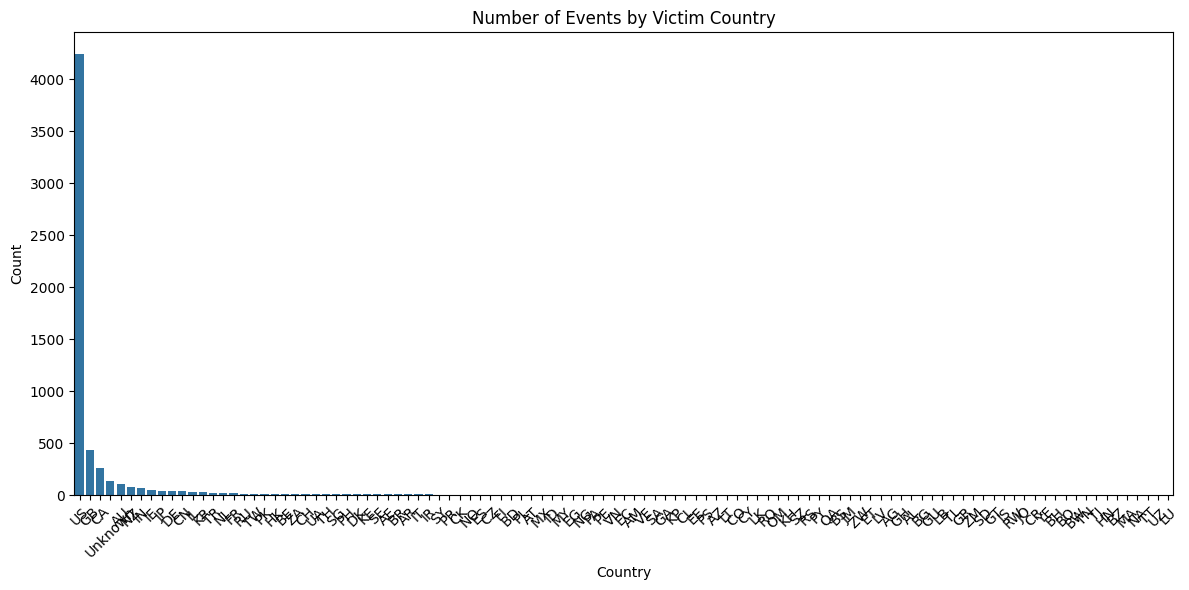

In [12]:
# count victim country
from collections import Counter
events_victim_country_df = pd.DataFrame(events_victim_country_only)
country_counts = events_victim_country_df['country'].value_counts()
print(country_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Number of Events by Victim Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

name
Unknown                              69
US National Security Agency (NSA)    14
Department of Veterans Affairs       10
Experian                             10
Internal Revenue Service              8
                                     ..
Axis Bank Limited                     1
Kirkland Village                      1
Cricfire                              1
Japan Pension Service                 1
BHcare, Inc.                          1
Name: count, Length: 4988, dtype: int64


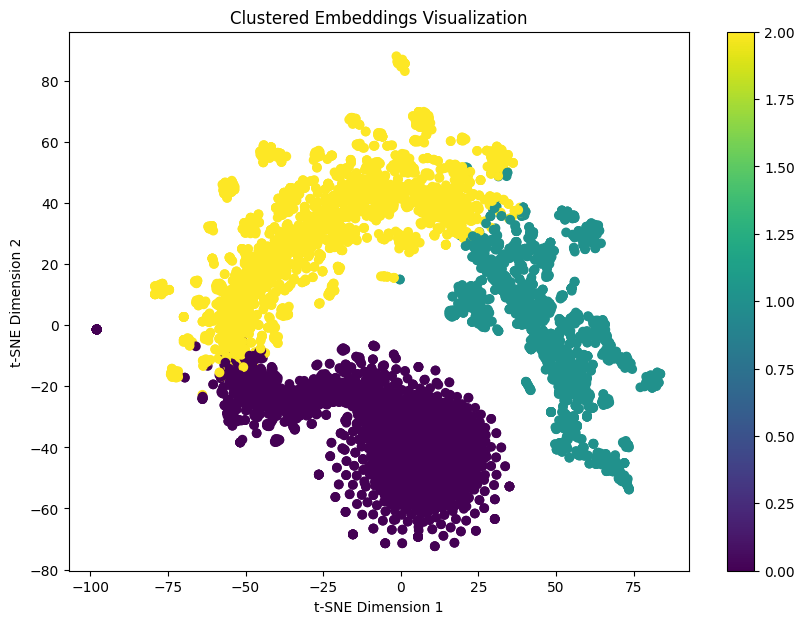

Cluster sizes: {0: 2047, 1: 1537, 2: 2340}

Cluster 0 top 5 values:
1. Feinstein Institute
2. housing.com
3. Artech Information Systems
4. Mass Event
5. Unknown

Cluster 1 top 5 values:
1. Bluewater Health
2. University of Massachusetts Amherst
3. Biogenesis of America
4. Riot Games, Inc.
5. US Department of the Air Force

Cluster 2 top 5 values:
1. Huerfano County
2. Western Missouri Medical Center
3. Marine Credit Union
4. Brown University
5. NOVA Chiropractic & Rehab Center


In [16]:
# analyze victim type with clustering
from collections import Counter
import nltk
from gensim.models import Word2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns



events_victim_name_df = pd.DataFrame(events_victim_name)
country_counts = events_victim_name_df['name'].value_counts()
print(country_counts)

def get_embeddings(string_list):
    tokenized_strings = [nltk.word_tokenize(text) for text in string_list]
    word2vec_model = Word2Vec(tokenized_strings, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = []
    for text in string_list:
        words = nltk.word_tokenize(text)
        vector = np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv], axis=0)
        embeddings.append(vector)

    return np.array(embeddings)

def cluster_and_plot_embeddings(embeddings, n_clusters=3):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=29)
    labels = kmeans.fit_predict(embeddings)

    # Reduce dimensionality for visualization using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create visualization
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Clustered Embeddings Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

    # Print cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    print("Cluster sizes:", dict(zip(unique, counts)))

    return labels


def print_top_cluster_values(texts, labels, n_top=5):
    # Create a dictionary to store texts for each cluster
    cluster_texts = {}
    for text, label in zip(texts, labels):
        if label not in cluster_texts:
            cluster_texts[label] = []
        cluster_texts[label].append(text)

    # Print top values for each cluster
    for cluster_id in sorted(cluster_texts.keys()):
        print(f"\nCluster {cluster_id} top {n_top} values:")
        cluster_values = cluster_texts[cluster_id][:n_top]
        for idx, value in enumerate(cluster_values, 1):
            print(f"{idx}. {value}")



embeddings = get_embeddings(events_victim_name_df['name'].tolist())
labels = cluster_and_plot_embeddings(embeddings, n_clusters=3)

print_top_cluster_values(events_victim_name_df['name'].tolist(), labels)

In [ ]:

# 递归函数修改嵌套字典
def modify_dict(data, keys_to_remove=None, keys_to_keep=None):
    if isinstance(data, dict):
        if keys_to_remove:
            for key in keys_to_remove:
                if key in data:
                    del data[key]
        if keys_to_keep:
            keys_to_keep_set = set(keys_to_keep)
            keys_to_delete = set(data.keys()) - keys_to_keep_set
            for key in keys_to_delete:
                del data[key]
        # 递归处理子字典
        for key, value in data.items():
            if isinstance(value, dict):
                modify_dict(value, keys_to_remove, keys_to_keep)
    elif isinstance(data, list):
        for item in data:
            modify_dict(item, keys_to_remove, keys_to_keep)

# 修改字典数据
for item in extracted_events:
    if 'actor' in item:
        modify_dict(item['actor'], keys_to_remove=keys_to_remove_actor)
    if 'asset' in item:
        modify_dict(item['asset'], keys_to_remove=keys_to_remove_asset)
    if 'timeline' in item:
        modify_dict(item['timeline'], keys_to_remove=keys_to_remove_timeline)
    if 'victim' in item:
        modify_dict(item['victim'], keys_to_keep=keys_to_keep_victim)
    if 'impact' in item:
        modify_dict(item['impact'], keys_to_keep=keys_to_keep_impact)
# 将提取的数据转换为DataFrame
df_extracted_events = pd.DataFrame(extracted_events)
# 打印提取后的数据数量和示例
print(f"提取后的事件数: {len(extracted_events)}")

##1.3数据清洗和规范化##
# 初始化停用词和词干提取器
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
# 遍历所有行和所有列，并对文本数据进行处理
for col in df_extracted_events.columns:
    for i in range(len(df_extracted_events)):
        if isinstance(df_extracted_events.at[i, col], str):  # 仅对字符串数据进行处理
            # 去除前后空白符和转换为小写
            cleaned_text = df_extracted_events.at[i, col].strip().lower()
            # 去除标点符号和特殊字符
            cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
            # 分词
            tokens = nltk.word_tokenize(cleaned_text)
            # 去除停用词
            filtered_tokens = [word for word in tokens if word not in stop_words]
            # 词干提取（可选）
            stemmed_tokens = [ps.stem(word) for word in filtered_tokens]
            # 将处理后的文本数据合并为一个字符串
            cleaned_text = ' '.join(stemmed_tokens)
            # 更新DataFrame中的文本列
            df_extracted_events.at[i, col] = cleaned_text
        elif 'date' in col.lower():  # 处理日期列，将字符串转换为日期类型
            df_extracted_events[col] = pd.to_datetime(df_extracted_events[col])
# 验证数据清洗
def is_cleaned(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # 字符串列
            for val in df[col]:
                if isinstance(val, dict):  # 如果是字典对象，跳过
                    continue
                if not isinstance(val, str) or not val.islower() or re.search(r'[^\w\s]', val):
                    return False
        elif 'date' in col.lower():  # 日期列
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                return False
    return True
# 检查数据是否已清洗
if is_cleaned(df_extracted_events):
    print("数据已成功清洗")
else:
    print("数据清洗失败")

###2自然语言处理（词嵌入）###
# 获取所有处理后的文本数据
sentences = df_extracted_events.apply(lambda row: ' '.join(row.astype(str)), axis=1).tolist()
processed_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

# 训练Word2Vec模型
word2vec_model = Word2Vec(processed_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 将每行文本转换为向量
def get_sentence_vector(sentence, model):
    words = nltk.word_tokenize(sentence)
    vector = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    return vector

sentence_vectors = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in sentences])

# 检查是否所有向量都已成功生成
if np.isnan(sentence_vectors).any():
    print("向量生成失败，有NaN值存在")
else:
    print("向量生成成功")


# 标准化向量数据
scaler = StandardScaler()
sentence_vectors_scaled = scaler.fit_transform(sentence_vectors)
# 检查向量的均值和方差
mean_vector = np.mean(sentence_vectors_scaled, axis=0)
std_vector = np.std(sentence_vectors_scaled, axis=0)
print(f"向量均值: {mean_vector}")
print(f"向量方差: {std_vector}")


# 如果向量的维度较高，可以使用 t-SNE 进行降维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
sentence_vectors_tsne = tsne.fit_transform(sentence_vectors_scaled)
# 将 t-SNE 降维后的向量转换为 DataFrame 以便于可视化
df_tsne = pd.DataFrame(sentence_vectors_tsne, columns=['Dim1', 'Dim2'])
# 使用散点图可视化 t-SNE 降维后的向量数据
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Dim1', y='Dim2', data=df_tsne)
plt.title('t-SNE of Sentence Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# 使用肘部法找到合适的K值
inertia = []
K_range = range(1, 10)  # 假设我们在1到9之间选择K值
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(sentence_vectors_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# 使用轮廓系数找到合适的K值
silhouette_scores = []
K_range_silhouette = range(2, 10)  # 轮廓系数至少需要2个聚类
for k in K_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(sentence_vectors_scaled)
    silhouette_scores.append(silhouette_score(sentence_vectors_scaled, labels))
plt.figure(figsize=(10, 5))
plt.plot(K_range_silhouette, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()


# K均值聚类
k_best = int(input("请输入K值："))
kmeans = KMeans(n_clusters=k_best, random_state=0)
kmeans.fit(sentence_vectors_scaled)
labels = kmeans.labels_
# 查看每个聚类的大小
unique, counts = np.unique(labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("每个聚类的大小:", cluster_distribution)
# 获取每个聚类的质心
centroids = kmeans.cluster_centers_
print("聚类质心:\n", centroids)






